In [1]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import tntorch as tn
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from common import (get_mnist_loaders, MNISTModel, 
                    accuracy, learn, update_line,
                    nparams)

torch.set_default_dtype(torch.float32)

In [2]:
train, test = get_mnist_loaders("data", 100)
model = MNISTModel()

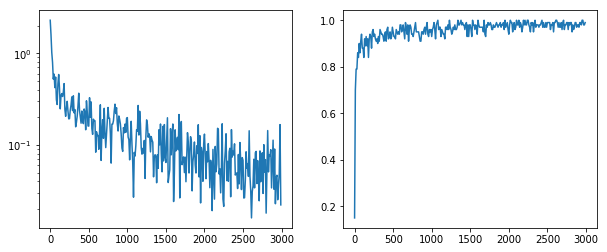

In [3]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
lossline, = axes[0].semilogy([])
lossline.set_data([], [])
accline, = axes[1].plot([])
accline.set_data([], [])

learner = learn(model, train, 5, optimizer, [accuracy])

for iters, losses, metrics in learner:
  
  clear_output(True)
  update_line(lossline, iters, losses)
  update_line(accline, iters, metrics[0])
  display(plt.gcf())
  
clear_output()

In [4]:
torch.tensor([accuracy(model(inputs), labels) 
              for inputs, labels in test]).mean()

tensor(0.9760)

In [5]:
model = MNISTModel()
model.load_state_dict(torch.load("base-model.pt"))

## Magnitude Pruning

In [6]:
model = MNISTModel()
model.load_state_dict(torch.load("base-model.pt"))

train, test = get_mnist_loaders("data", 100)

In [7]:
class MagnitudePrunningLayer(nn.Module):
  def __init__(self, layer, threshold):
    super().__init__()
    self.layer = layer
    self.threshold = threshold
    self.compress(self.threshold)
    
  def forward(self, inputs):
    return self.layer(inputs)
  
  def compress(self, threshold):
    assert threshold >= self.threshold
    self.threshold = threshold
    mask = (torch.abs(self.layer.weight) 
            > self.threshold).type(self.layer.weight.dtype)
    self.layer.weight.data.mul_(mask)

In [8]:
model.layers[0] = MagnitudePrunningLayer(model.layers[0], 0.1)

In [9]:
nepochs = 100

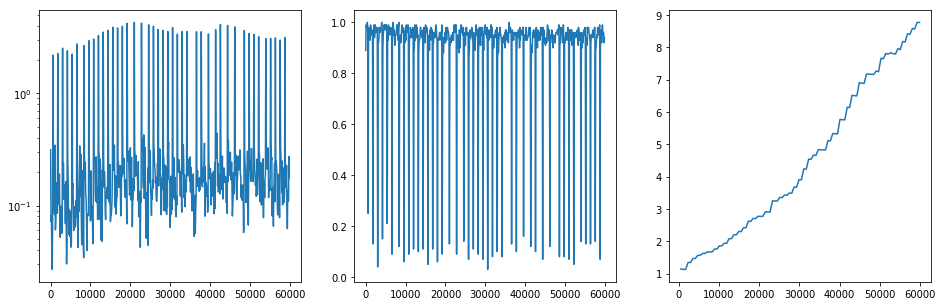

In [10]:
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)

learner = learn(model, train, nepochs, optimizer, 
                metrics=[accuracy], logperiod=100)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
lossline, = axes[0].semilogy([])
accline, = axes[1].plot([])
compline, = axes[2].plot([])
for line in (lossline, accline, compline):
  line.set_data([], [])

for epoch, (iters, loss, metrics) in enumerate(learner):
  clear_output(True)
  update_line(lossline, iters, loss)
  update_line(accline, iters, metrics[0])
  update_line(compline, [iters[-1]], [nparams(model) / nparams(model, True)])
  if np.mean(metrics[0]) > 0.95 and epoch != nepochs - 1:
    model.layers[0].compress(model.layers[0].threshold + 0.2)
  display(plt.gcf())
  
clear_output()

In [11]:
torch.tensor([accuracy(model(inputs), labels) 
              for inputs, labels in test]).mean()

tensor(0.9570)

In [12]:
nparams(model) / nparams(model, True)

8.76944288853462

## TT

### With fine-tuning

In [2]:
from copy import deepcopy

from tensor_net import TTLayer

In [3]:
model = MNISTModel()
model.load_state_dict(torch.load("base-model.pt"))
basemodel = deepcopy(model)

train, test = get_mnist_loaders("data", 100)

shapes = [[7, 4, 7, 4], [4, 4, 4, 4]]
ranks = [16 for _ in range(3)]
model.layers[0] = TTLayer(model.layers[0], shapes=shapes, ranks=ranks)

torch.tensor([accuracy(model(inputs), labels) 
              for inputs, labels in test]).mean()

tensor(0.5234)

In [4]:
[p.shape for p in model.parameters()]

[torch.Size([256]),
 torch.Size([1, 7, 4, 16]),
 torch.Size([16, 4, 4, 16]),
 torch.Size([16, 7, 4, 16]),
 torch.Size([16, 4, 4, 1]),
 torch.Size([10, 256]),
 torch.Size([10])]

In [5]:
model

MNISTModel(
  (layers): ModuleList(
    (0): TTLayer(
      (cores): ParameterList(
          (0): Parameter containing: [torch.FloatTensor of size 1x7x4x16]
          (1): Parameter containing: [torch.FloatTensor of size 16x4x4x16]
          (2): Parameter containing: [torch.FloatTensor of size 16x7x4x16]
          (3): Parameter containing: [torch.FloatTensor of size 16x4x4x1]
      )
    )
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [6]:
nepochs = 5

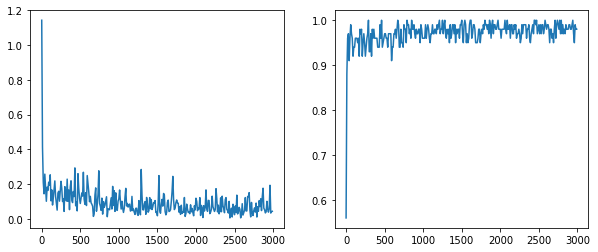

In [7]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

learner = learn(model, train, nepochs, optimizer, 
                metrics=[accuracy])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
lossline, = axes[0].plot([])
accline, = axes[1].plot([])
for line in (lossline, accline):
  line.set_data([], [])

for iters, loss, metrics in learner:
  clear_output(True)
  update_line(lossline, iters, loss)
  update_line(accline, iters, metrics[0])
  display(plt.gcf())
  
clear_output()

In [8]:
torch.tensor([accuracy(model(inputs), labels) 
              for inputs, labels in test]).mean()

tensor(0.9784)

In [9]:
nparams(basemodel) / nparams(model)

13.757604434230092

### Training from scratch

In [10]:
model = MNISTModel()

shapes = [[7, 4, 7, 4], [4, 4, 4, 4]]
ranks = [4 for _ in range(3)]
model.layers[0] = TTLayer(model.layers[0], shapes=shapes, ranks=ranks)

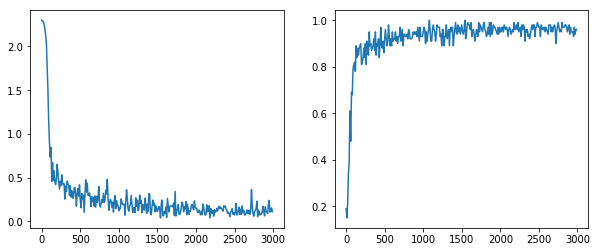

In [11]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

learner = learn(model, train, nepochs, optimizer, 
                metrics=[accuracy])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
lossline, = axes[0].plot([])
accline, = axes[1].plot([])
for line in (lossline, accline):
  line.set_data([], [])

for iters, loss, metrics in learner:
  clear_output(True)
  update_line(lossline, iters, loss)
  update_line(accline, iters, metrics[0])
  display(plt.gcf())
  
clear_output()

In [12]:
torch.tensor([accuracy(model(inputs), labels) 
              for inputs, labels in test]).mean()

tensor(0.9647)

In [13]:
nparams(basemodel) / nparams(model)

54.91905018888289